## Install Dependencies

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install jsonlines

## Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import copy
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import jsonlines
import os

In [4]:
scaler = MinMaxScaler()
hidden_dim = 512
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Files
train_file = '/kaggle/input/nlp-deception/train.jsonl'
val_file = '/kaggle/input/nlp-deception/validation.jsonl'
test_file = '/kaggle/input/nlp-deception/test.jsonl'

train_embed_path = "/kaggle/input/nlp-deception-encoded/train_embeddings.pt"
val_embed_path = "/kaggle/input/nlp-deception-encoded/val_embeddings.pt"
test_embed_path = "/kaggle/input/nlp-deception-encoded/test_embeddings.pt"

## Data Loading

In [6]:
# Load and clean the dataset
def load_flattened_dataset(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for game in reader:
            for i in range(len(game["messages"])):
                if game["sender_labels"][i] == "NOANNOTATION":
                    continue
                data.append({
                    "message": game["messages"][i],
                    "sender_label": int(game["sender_labels"][i] == False),
                    "receiver_label": game["receiver_labels"][i],
                    "speaker": game["speakers"][i],
                    "receiver": game["receivers"][i],
                    "abs_msg_idx": game["absolute_message_index"][i],
                    "rel_msg_idx": game["relative_message_index"][i],
                    "season": game["seasons"][i],
                    "year": game["years"][i],
                    "score": game["game_score"][i],
                    "score_delta": float(game["game_score_delta"][i]),
                    "game_id": game["game_id"],
                    "players": game["players"],
                    "message_length": len(game["messages"][i])
                })
    return pd.DataFrame(data)

In [7]:
# Embed messages using LLM2Vec
def extract_metadata(df):
    metadata_features = df[["abs_msg_idx", "rel_msg_idx", "year", "score", 
                             "score_delta", "message_length"]].values
    metadata_features = scaler.fit_transform(metadata_features)
    return metadata_features

In [8]:
# Extract Player features
def player_features(df):
    players = np.unique(df[["speaker", "receiver"]].values.flatten())
    player_node_features = np.eye(len(players))
    return player_node_features

In [9]:
# Pad with zeros
def pad_player_features(player_features, padding_dim):
    return np.pad(player_features, ((0, 0), (0, padding_dim)), 'constant')

In [10]:
# Load datasets
def load_datasets(train_file, val_file, test_file):
    df_train = load_flattened_dataset(train_file)
    df_val = load_flattened_dataset(val_file)
    df_test = load_flattened_dataset(test_file)
    return df_train, df_val, df_test

In [11]:
# Load embeddings
def load_embeddings(train_path, val_path, test_path):
    X_train, y_train = torch.load(train_path)
    X_val, y_val = torch.load(val_path)
    X_test, y_test = torch.load(test_path)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

## Build Graph

In [12]:
# Build edge list for the graph
def build_bidirectional_edge_list(df, player_encoder):
    edges = []
    num_messages = len(df)
    player_offset = num_messages  # player nodes start after message nodes

    for i in range(num_messages - 1):
        # Temporal edges: message i <-> message i+1
        edges.append((i, i + 1))
        edges.append((i + 1, i))

    for i, row in df.iterrows():
        speaker_id = player_offset + player_encoder.transform([row["speaker"]])[0]
        receiver_id = player_offset + player_encoder.transform([row["receiver"]])[0]

        # Speaker <-> message
        edges.append((speaker_id, i))   # player → message
        edges.append((i, speaker_id))   # message → player

        # Receiver <-> message
        edges.append((receiver_id, i))
        edges.append((i, receiver_id))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

In [13]:
# Prepare graph data from dataframes and embeddings.
def prepare_graph_data(df_train, df_val, df_test, embeddings):
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = embeddings
    
    # Extract metadata features
    train_metadata_features = extract_metadata(df_train)
    val_metadata_features = extract_metadata(df_val)
    test_metadata_features = extract_metadata(df_test)

    # Final message node features
    train_message_node_features = np.hstack([X_train, train_metadata_features])
    test_message_node_features = np.hstack([X_test, test_metadata_features])
    val_message_node_features = np.hstack([X_val, val_metadata_features])

    # Player node features
    train_player_node_features = player_features(df_train)
    val_player_node_features = player_features(df_val)
    test_player_node_features = player_features(df_test)

    message_dim = train_message_node_features.shape[1]
    player_dim = train_player_node_features.shape[1]
    padding_dim = message_dim - player_dim

    # Pad player features
    train_player_node_features_padded = pad_player_features(train_player_node_features, padding_dim)
    val_player_node_features_padded = pad_player_features(val_player_node_features, padding_dim)
    test_player_node_features_padded = pad_player_features(test_player_node_features, padding_dim)

    # Concatenate features
    train_x = torch.tensor(np.vstack([train_message_node_features, train_player_node_features_padded]), 
                           dtype=torch.float32)
    test_x = torch.tensor(np.vstack([test_message_node_features, test_player_node_features_padded]), 
                          dtype=torch.float32)
    val_x = torch.tensor(np.vstack([val_message_node_features, val_player_node_features_padded]), 
                         dtype=torch.float32)

    # Create common player encoder
    all_players = pd.concat([df_train[["speaker", "receiver"]],
                         df_val[["speaker", "receiver"]],
                         df_test[["speaker", "receiver"]]]).values.flatten()
    player_encoder = LabelEncoder().fit(all_players)

    # Generate edges
    train_edge_index = build_bidirectional_edge_list(df_train, player_encoder)
    val_edge_index = build_bidirectional_edge_list(df_val, player_encoder)
    test_edge_index = build_bidirectional_edge_list(df_test, player_encoder)

    # Create graph data objects
    train_data = Data(x=train_x, edge_index=train_edge_index, y=y_train).to(device)
    val_data = Data(x=val_x, edge_index=val_edge_index, y=y_val).to(device)
    test_data = Data(x=test_x, edge_index=test_edge_index, y=y_test).to(device)
    
    return train_data, val_data, test_data, train_x.shape[1]

## Model

In [14]:
# Define the GAT model
class GATDeceptionClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, dropout=0.3)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=2, dropout=0.3)
        self.out = torch.nn.Linear(hidden_dim * 2, 1)
        self.out_dim = hidden_dim * 2

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        return self.out(x).squeeze()  # logits

In [15]:
def BCE_loss(data):
    labels = data.y.cpu().numpy()
    class_weights = compute_class_weight("balanced", classes=[0, 1], y=labels)
    pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(device)

    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    return criterion

## Training

In [17]:
# Train the model
def train_model(train_data, test_data, input_dim, hidden_dim=512, 
                lr=2e-5, num_epochs=500, checkpoint_dir="checkpoints"):
    # Create directories for checkpoints
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
        
    # Initialize model and optimizer
    model = GATDeceptionClassifier(input_dim, hidden_dim).to(device)
    criterion = BCE_loss(train_data)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    # Training tracking variables
    best_score = 0
    best_model = GATDeceptionClassifier(input_dim, hidden_dim).to(device)
    losses = []
    macro_f1s = []
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()

        edge_index = train_data.edge_index.clone()
        
        # Forward pass with fresh tensors
        logits = model(train_data.x, edge_index)
        train_logits = logits[:len(train_data.y)]
        loss = criterion(train_logits, train_data.y)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            eval_logits = model(test_data.x, test_data.edge_index)
            eval_output = eval_logits[:len(test_data.y)].clone()
            preds = torch.sigmoid(eval_output).cpu().numpy()
            pred_labels = (preds > 0.5).astype(int)

        print(f"\nEpoch {epoch} | Loss: {loss.item():.4f}")
        score_f1 = f1_score(test_data.y.cpu().numpy(), pred_labels, average='macro')
        print("Test Report:\n", classification_report(test_data.y.cpu().numpy(), pred_labels, 
                                                     digits=4, zero_division=0))
        print("Test Macro F1:", score_f1)
        
        losses.append(loss.item())
        macro_f1s.append(score_f1)
        
        # Save best model
        if score_f1 > best_score:
            best_score = score_f1
            print("New Best:", best_score, "epoch:", epoch)
            best_model.load_state_dict(copy.deepcopy(model.state_dict()))
            torch.save(model.state_dict(), f"best_model.pth")
            
        # Periodic checkpoints
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"{checkpoint_dir}/model_epoch_{epoch}.pth")
    
    print("Best Score:", best_score)
    
    return best_model, losses, macro_f1s

In [28]:
# Evaluate
def evaluate(model, data, t=0.5, output_dict=False):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)[:len(data.y)]
        preds = torch.sigmoid(logits).cpu().numpy()
        pred_labels = (preds > t).astype(int)
        cm = confusion_matrix(data.y.cpu().numpy(), pred_labels)
        return (classification_report(data.y.cpu().numpy(), pred_labels, digits=4, 
                                     output_dict=output_dict, zero_division=0),
               f1_score(data.y.cpu().numpy(), pred_labels, average='macro'), cm)

In [18]:
# Tune classification threshold and plot results
def tune_threshold(model, test_data):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
    metrics = {"threshold": [], "f1": [], "precision": [], "recall": []}

    for t in thresholds:
        rep, f1, _ = evaluate(model, test_data, t, True)
        prec = rep['macro avg']['precision'] 
        rec = rep['macro avg']['recall']   
        metrics["threshold"].append(t)
        metrics["f1"].append(f1)
        metrics["precision"].append(prec)
        metrics["recall"].append(rec)
    
    # Plot metrics vs threshold
    plt.figure(figsize=(8, 5))
    plt.plot(metrics["threshold"], metrics["f1"], label="F1", marker="o")
    plt.plot(metrics["threshold"], metrics["precision"], label="Precision", marker="s")
    plt.plot(metrics["threshold"], metrics["recall"], label="Recall", marker="^")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Tuning on Test Set")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return metrics

In [19]:
# Plot training loss and F1 score history.
def plot_training_history(losses, macro_f1s):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.plot(macro_f1s, label='Macro F1')
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Training Loss and Macro F1 Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

## Start

In [20]:
# Load data
df_train, df_val, df_test = load_datasets(train_file, val_file, test_file)

In [21]:
# Load embeddings
embeddings = load_embeddings(train_embed_path, val_embed_path, test_embed_path)

/tmp/ipykernel_31/1070986595.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train, y_train = torch.load(train_path)
/tmp/ipykernel_31/1070986595.py:5: FutureWarning: 

In [22]:
# Prepare data
train_data, val_data, test_data, input_dim = prepare_graph_data(
    df_train, df_val, df_test, embeddings
)

In [27]:
val_data

Data(x=[1423, 2054], edge_index=[2, 8494], y=[1416])

In [23]:
# Train Model
best_model, losses, macro_f1s = train_model(
    train_data, test_data, input_dim, hidden_dim=hidden_dim
)


Epoch 1 | Loss: 1.3775
Test Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      2501
         1.0     0.0876    1.0000    0.1610       240

    accuracy                         0.0876      2741
   macro avg     0.0438    0.5000    0.0805      2741
weighted avg     0.0077    0.0876    0.0141      2741

Test Macro F1: 0.08050989600805099
New Best: 0.08050989600805099 epoch: 1

Epoch 2 | Loss: 1.3848
Test Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      2501
         1.0     0.0876    1.0000    0.1610       240

    accuracy                         0.0876      2741
   macro avg     0.0438    0.5000    0.0805      2741
weighted avg     0.0077    0.0876    0.0141      2741

Test Macro F1: 0.08050989600805099

Epoch 3 | Loss: 1.3635
Test Report:
               precision    recall  f1-score   support

         0.0     0.9167    0.1144    0.2033      2501
         1.0  

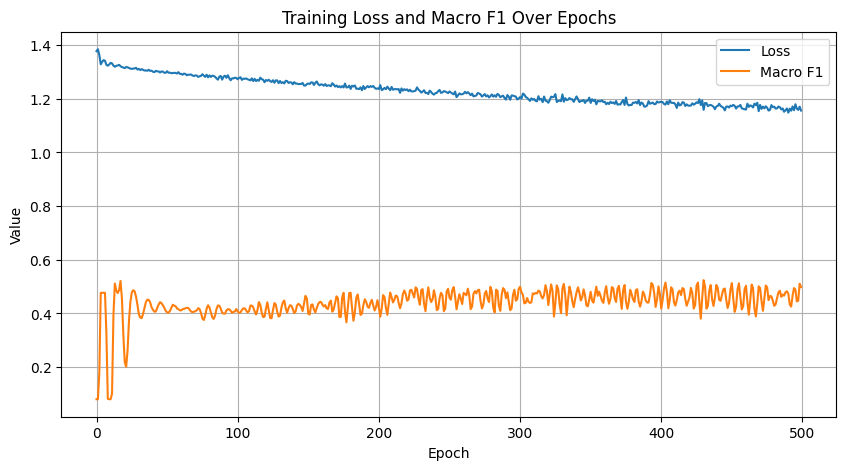

In [24]:
# Plot
plot_training_history(losses, macro_f1s)

In [29]:
# Evaluate
val_report, val_f1, val_cm = evaluate(best_model, val_data)
test_report, test_f1, test_cm = evaluate(best_model, test_data)

print("Validation Results:\n", val_report, "\nMacro F1:", val_f1)
print("Test Results:\n", test_report, "\nMacro F1:", test_f1)

Validation Results:
               precision    recall  f1-score   support

         0.0     0.9623    0.8265    0.8892      1360
         1.0     0.0484    0.2143    0.0789        56

    accuracy                         0.8023      1416
   macro avg     0.5054    0.5204    0.4841      1416
weighted avg     0.9262    0.8023    0.8572      1416
 
Macro F1: 0.4840939373750832
Test Results:
               precision    recall  f1-score   support

         0.0     0.9182    0.8792    0.8983      2501
         1.0     0.1272    0.1833    0.1502       240

    accuracy                         0.8183      2741
   macro avg     0.5227    0.5313    0.5242      2741
weighted avg     0.8489    0.8183    0.8328      2741
 
Macro F1: 0.5242274810948271


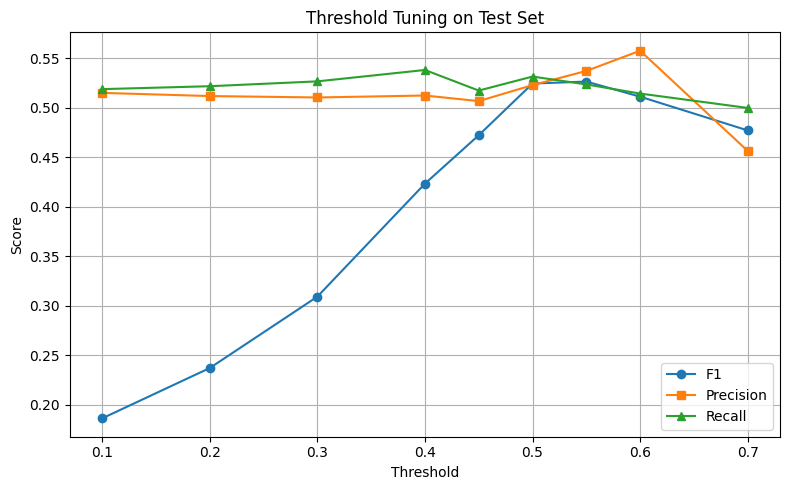

In [30]:
# Threshold tuning
metrics = tune_threshold(best_model, test_data)

In [31]:
# !zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/best_model.pth (deflated 8%)
  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/model_epoch_130.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_340.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_350.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_410.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_50.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_200.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_190.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_500.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_180.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_430.pth (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_420.pth (deflated 8%)
  adding: kaggle/work